### K Nearest kNN Source Separation Algorithm
### Matthew Yeseta

### Source separation involves separating mixed signals into their original components. Adapting k-NN for source separation involves using the algorithm to find similar patterns or components in the mixed signal that correspond to the original sources

Algorithm steps for k-NN Source Separation Algorithm

1. Feature Extraction: Transform mixed signal into a feature space where patterns corresponding to different sources can be more easily identified. Feature space using Short-Time Fourier Transform (STFT).

2. Prepare Training Data: Isolated source signals and corresponding mixed signals. The STFT feature representations of these signals will be used to train the k-NN model.

3. Train the k-NN Model: For each point in the feature space of the training data, store the corresponding source label or characteristics.

4. Predict Source Components: For each point in the feature space of the mixed signal, find the 𝑘 nearest neighbors in the training data. Use characteristics of these neighbors to predict the source component corresponding to the point in the mixed signal.

5. Reconstruct the Separated Signals using the predictions from the k-NN model, reconstruct the separated source signals in the time domain.


In [3]:
import os
import numpy as np
import librosa as lb
import librosa 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.io import loadmat
from scipy.io import wavfile
import scipy.signal
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dir_path = 'C:\\Users\\matth\\Documents\\master-degree\\data'
os.chdir(dir_path)
dir_path = os.getcwd()

base_path = 'C:\\Users\\matth\\Documents\\master-degree\\data\\'
source = base_path + "trs.wav"

trs_wave, sr1 = librosa.load(source, sr = None)
trn_wave, sr1 = librosa.load(base_path + "trn.wav", sr = None)
x_nmf_wave, sr1 = librosa.load(base_path + "x_nmf.wav", sr = None)

### K Nearest kNN Source Separation Algorithm

Custom K Nearest kNN Source Separation Algorithm. Here we are specifically focusing on Discrete Fourier Transform (DFT) application for spectral analysis, performing windowing spectral signals with a Hann window, classifying using a k-Nearest Neighbors (kNN) algorithm, and reconstructing signals from their spectral components, and classifying using a k-Nearest Neighbors (kNN) algorithm. The goal is to perform audio source separation and noise reduction.

### get_dft_matrix(N_size): 
 
Generates the DFT matrix for a given size N_size, is used as basis matrix to transform a signal from the time domain to the frequency domain.

### get_inverse_dft_matrix(N_size): 
 
Creates the inverse DFT matrix for a given size N_size, used to transform a signal back from the frequency domain to the time domain.

### hann_window_matrix(signal, N):  
 
Applies a Hann window to segments of the input signal spectral analysis. The signal is divided into frames of length N, each multiplied by a Hann window before being appended to a matrix. This process is useful for spectral analysis to minimize edge effects.

### reverse_overlap(signal, N): 
 
Aims to reconstruct the time-domain signal from its windowed frames by adding overlaps between consecutive frames. This method is crucial for reconstructing a signal after it has been processed in the frequency domain.

### kNN_classifier(test, train, kNN_K): 
 
Implements the k-Nearest Neighbors algorithm, computes the distance between each test vector and train vectors, returning the indices of the kNN_K closest training vectors for each test vector.

### get_ideal_binary_mast_prediction(matrix, B): 
 
Calculates the ideal binary mask (IBM) for source separation. Given a matrix of selected neighbor index and a binary mask B, computes the median across the selected neighbors for each frequency bin to predict the mask.

### get_noise_matrix(trs_wave, trn_wave, N): 
 
Computes the spectral representations of two signals using a Hann window and the DFT matrix. This function returns the magnitude spectra of both signals for noise reduction efforts.

### get_separate_sources(x_nmf_wave, N, dftmatrix): 
 
Separates audio sources from a mixed signal using the provided DFT matrix and a Hann window, generates the magnitude spectrum of the mixed signal.

### get_conjugate(hat): 
 
Generates the conjugate of a spectrum, excluding the DC component, to support the reconstruct of the full spectrum from a half spectrum obtained from real signals.

### concatenate_conjugate(S, C): 
 
Concatenates a spectrum with its conjugate to form a complete spectrum. 


In [5]:
N = 1024
k = 25

def get_dft_matrix(N_size):
    matrix = np.array([[np.exp(-1j*(2*np.pi*f*n/N_size)) for f in range(0,N_size)] for n in range(0,N_size)])
    return matrix

def get_inverse_dft_matrix(N_size):
    matrix = np.array([[np.exp(1j*(2*np.pi*f*n/N_size)) for f in range(0,N_size)] for n in range(0,N_size)])/N_size
    return matrix

def hann_window_matrix(signal, N):
    matrix = []
    n = 0
    hann = np.hanning(N)
    while n+N <= len(signal):
        w = signal[n:n+N]
        v = np.multiply(w, hann)
        matrix.append(v)
        n = n + int(N/2)
    matrix = np.array(matrix)
    return matrix.T


def reverse_overlap(signal, N):
    RO_out = signal[:(signal.shape[0] - int(N/2)),0]
    for col in range(1, signal.shape[1]):
        RO_col = signal[(signal.shape[0] - int(N/2)):,col-1] + signal[0:int(N/2),col]
        RO_out = np.concatenate((RO_out, RO_col))   
    RO_out = RO_out.reshape(-1)   
    return RO_out

def kNN_classifier(test, train, kNN_K):
    matrix = np.zeros((test.shape[1], train.shape[1]))
    for j in range(0, test.shape[1]):
        for k in range(0, train.shape[1]):
            matrix[j][k] = np.sqrt(np.sum(np.power((train[:,k] - test[:,j]), 2)))  
    return matrix.argsort()[:,0:kNN_K]

def get_ideal_binary_mast_prediction(matrix, B):
    ibmD = np.zeros((B.shape[0], matrix.shape[0]))
    for i in range(0, matrix.shape[0]):
        ibmD[:,i] = np.median(B[:,matrix[i,:]], axis=1)
    return ibmD

def get_noise_matrix(trs_wave, trn_wave, N):
    trs_hann = hann_window_matrix(trs_wave, N)
    trs_spectogram = np.dot(dft_matrix, trs_hann)
    trs_spectogram_split = trs_spectogram[0:513,:]
    trs_noise = np.abs(trs_spectogram_split)    
    trn_hann = hann_window_matrix(trn_wave, N)
    trn_spectogram = np.dot(dft_matrix, trn_hann)
    trn_spectogram_split = trn_spectogram[0:513,:]
    trn_noise = np.abs(trn_spectogram_split)
    return trs_noise, trn_noise  
    
def get_separate_sources(x_nmf_wave, N, dftmatrix):
    hann = hann_window_matrix(x_nmf_wave, N)
    spectogram = np.dot(dftmatrix, hann)
    X = spectogram[0:513,:]
    Y = np.abs(X) 
    return X, Y

def get_conjugate(hat):
    result = np.flip(np.conjugate(hat[1:512, :]), axis = 0)
    return result
    
def concatenate_conjugate(S, C):
    result = np.concatenate((S, C), axis = 0)
    return result
  

This the the noise reduction process using Discrete Fourier Transform (DFT), k-Nearest Neighbors (kNN) classification, and Ideal Binary Mask (IBM).

### DFT Matrix Generation: 
The get_dft_matrix(N) function creates a DFT matrix for a given size N. This matrix is instrumental in converting time-domain signals into their frequency-domain representations.

### Noise and Signal Spectra Calculation: 
The get_noise_matrix(trs_wave, trn_wave, N) function calculates the noise and signal spectra from two separate waveforms (trs_wave and trn_wave), both of which are components of an observed noisy signal. These spectra are obtained by applying the DFT to windowed segments of the waveforms.

### Source Separation: 
The get_separate_sources(x_nmf_wave, N, dft_matrix) function applies the DFT matrix to a mixed signal x_nmf_wave to separate the sources within it, generating a magnitude spectrum Y of the mixed signal.

### Composite Noise Spectrum: 
The sum of the noise spectra from the two sources (trs_noise and trn_noise) is calculated to form a composite noise spectrum G.

### kNN Classification: 
The kNN_classifier(Y, G, k) function classifies the frequency bins of the mixed signal's spectrum Y against the composite noise spectrum G using k-Nearest Neighbors, aiming to identify which parts of the signal spectrum are dominated by noise.

### Ideal Binary Mask Prediction: 
An ideal binary mask (IBM) ibm_mask is created, indicating whether the signal or noise dominates at each frequency bin. The get_ideal_binary_mast_prediction(kNN_matrix, ibm_mask) function applies this mask based on the classification results, aiming to retain the signal-dominated parts of the spectrum while reducing the noise-dominated parts.

### Spectral Mask Application: 
The predicted IBM D is multiplied by the mixed signal's spectrum X to generate a noise-reduced spectrum S_hat_test.

### Spectrum Reconstruction: 
The conjugate of S_hat_test is obtained using get_conjugate(S_hat_test) and concatenated to itself with concatenate_conjugate(S_hat_test, S_hat_conjugate) to reconstruct the full frequency spectrum.

### Inverse DFT and Signal Reconstruction: 
The full spectrum is transformed back to the time domain using the inverse DFT matrix obtained from get_inverse_dft_matrix(N). The resulting time-domain signal S_hat_time is then reconstructed by overlapping and adding the inverse-transformed frames with reverse_overlap(S_hat.real, N).

In [6]:
dft_matrix = get_dft_matrix(N)
trs_noise, trn_noise = get_noise_matrix(trs_wave, trn_wave, N)

X, Y = get_separate_sources(x_nmf_wave, N, dft_matrix)
G = trs_noise + trn_noise
kNN_matrix = kNN_classifier(Y, G, k)

ibm_mask = (trs_noise >= trn_noise).astype(int)
D = get_ideal_binary_mast_prediction(kNN_matrix, ibm_mask)

S_hat_test = D * X

S_hat_conjugate = get_conjugate(S_hat_test)
S_hat_test = concatenate_conjugate(S_hat_test, S_hat_conjugate)

S_hat = np.dot(get_inverse_dft_matrix(N), S_hat_test)
S_hat_time = reverse_overlap(S_hat.real, N)

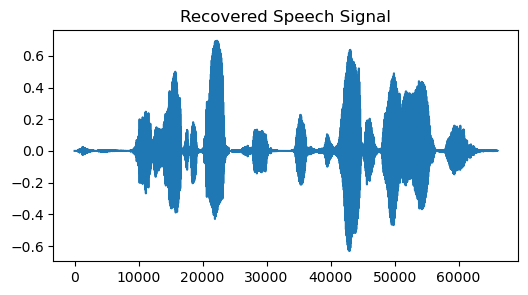

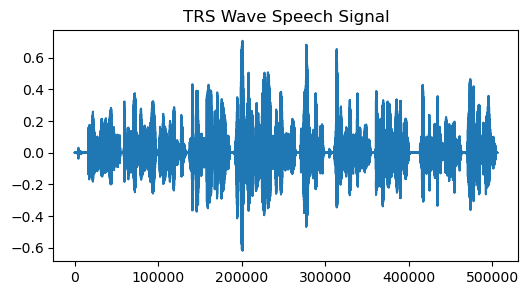

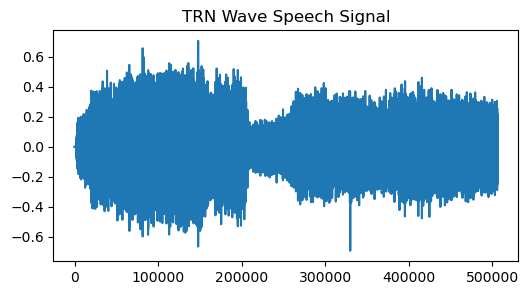

In [7]:
x_range = range(S_hat_time.shape[0])
plt.figure(figsize= (6,3))
plt.title("Recovered Speech Signal")
plt.plot(x_range, S_hat_time)
plt.show()


plt.figure(figsize= (6,3))
plt.title("TRS Wave Speech Signal")
plt.plot(trs_wave)
plt.show()
    
plt.figure(figsize= (6,3))
plt.title("TRN Wave Speech Signal")
plt.plot(trn_wave)
plt.show()

